In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn

from sklearn.model_selection import train_test_split 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression ,Ridge #  LinearRegression, Ridge 예측, LogisticRegression 분류

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, SVR #분류/예측

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN

from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 


from sklearn.tree import export_graphviz
import graphviz
import os
os.environ['PATH'] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

1. stock market prediction > regression
   input : 한국 KOSPI + 미국 DJIA 검색
   output : KOSPI 미래의 1개월간(1일)의 종가 예측
   - KOSPI : https://finance.naver.com/sise/sise_index_day.nhn?code=KOSPI&page=##
   - DJIA : https://finance.yahoo.com/quote/%5EDJI/history?period1=1531810422&period2=1563346422&interval=1d&filter=history&frequency=1d
      > 다운로드 받아서 사용으로 대체
   - 2018.07.17 ~ 현재까지 1년치 데이터 사용

In [2]:
kospi_url='https://finance.naver.com/sise/sise_index_day.nhn?code=KOSPI&page='

In [3]:
tables = pd.read_html(kospi_url+'1')
tables[0]

,날짜,체결가,전일비,등락률,거래량(천주),거래대금(백만)
0,NaN,NaN,NaN,NaN,NaN,NaN
1,2019.07.17,2072.92,18.95,-0.91%,752119.0,4549215.0
2,2019.07.16,2091.87,9.39,+0.45%,674500.0,5158374.0
3,2019.07.15,2082.48,4.18,-0.20%,455075.0,3656611.0
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,2019.07.12,2086.66,6.08,+0.29%,398353.0,3714594.0
9,2019.07.11,2080.58,21.80,+1.06%,368242.0,4934006.0


In [4]:
kospis = []
max_num = 42
for i in range(1,max_num):
    tables = pd.read_html(kospi_url+str(i))
    kospi = tables[0]
    kospis.append(kospi)
len(kospis)

41

In [5]:
kospi = pd.concat(kospis, axis=0)
kospi.shape

(533, 6)

In [6]:
kospi.tail(10)

,날짜,체결가,전일비,등락률,거래량(천주),거래대금(백만)
3,2018.07.20,2289.19,6.90,+0.30%,346880.0,4839036.0
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,2018.07.19,2282.29,7.82,-0.34%,458752.0,5346881.0
9,2018.07.18,2290.11,7.81,-0.34%,395774.0,4838320.0
10,2018.07.17,2297.92,4.07,-0.18%,365351.0,4696497.0
11,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
kospi = kospi.set_index('날짜')

In [8]:
#1년치 url이 잘 되지 않으므로 다운로드 후 read!!
#djia_url = 'https://finance.yahoo.com/quote/%5EDJI/history?period1=1531810422&period2=1563346422&interval=1d&filter=history&frequency=1d'


In [9]:
#tables = pd.read_html(djia_url)
#len(tables)

In [10]:
#tables[0].head(), tables[0].info()

In [11]:
#djia=tables[0]

In [12]:
djia = pd.read_csv('^DJI.csv')

In [13]:
djia.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
246,2019-07-10,26851.960938,26983.449219,26813.109375,26860.199219,26860.199219,207990000
247,2019-07-11,26950.160156,27088.449219,26916.320313,27088.080078,27088.080078,252300000
248,2019-07-12,27139.490234,27333.789063,27135.449219,27332.029297,27332.029297,248390000
249,2019-07-15,27364.689453,27364.689453,27294.169922,27359.160156,27359.160156,199730000
250,2019-07-16,27349.320313,27398.679688,27290.240234,27335.630859,27335.630859,223850000


In [14]:
#djia = djia.iloc[:-1,:]

In [15]:
#djia.tail()

In [16]:
djia = djia.set_index('Date')

In [17]:
kospi.index, djia.index

(Index([         nan, '2019.07.17', '2019.07.16', '2019.07.15',          nan,
                 nan,          nan,          nan, '2019.07.12', '2019.07.11',
        ...
        '2018.07.20',          nan,          nan,          nan,          nan,
        '2018.07.19', '2018.07.18', '2018.07.17',          nan,          nan],
       dtype='object', name='날짜', length=533),
 Index(['2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20', '2018-07-23',
        '2018-07-24', '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-30',
        ...
        '2019-07-02', '2019-07-03', '2019-07-05', '2019-07-08', '2019-07-09',
        '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-15', '2019-07-16'],
       dtype='object', name='Date', length=251))

In [18]:
kospi.index = pd.to_datetime(kospi.index)

In [19]:
djia.index

Index(['2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20', '2018-07-23',
       '2018-07-24', '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-30',
       ...
       '2019-07-02', '2019-07-03', '2019-07-05', '2019-07-08', '2019-07-09',
       '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-15', '2019-07-16'],
      dtype='object', name='Date', length=251)

In [20]:
djia.index = pd.to_datetime(djia.index)

In [21]:
df = pd.concat((kospi, djia), axis=1).dropna()
df.shape

(237, 11)

In [22]:
df.dtypes

체결가          float64
전일비          float64
등락률           object
거래량(천주)      float64
거래대금(백만)     float64
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [23]:
df = df.replace('%','',regex=True)

In [24]:
df['등락률'] = df['등락률'].astype(np.float)
df.dtypes

체결가          float64
전일비          float64
등락률          float64
거래량(천주)      float64
거래대금(백만)     float64
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [25]:
df.sum()

체결가          5.124601e+05
전일비          3.163870e+03
등락률         -8.300000e+00
거래량(천주)      9.248564e+07
거래대금(백만)     1.231396e+09
Open         6.049191e+06
High         6.080727e+06
Low          6.015552e+06
Close        6.050631e+06
Adj Close    6.050631e+06
Volume       7.334145e+10
dtype: float64

In [26]:
df.mean()

체결가          2.162279e+03
전일비          1.334966e+01
등락률         -3.502110e-02
거래량(천주)      3.902347e+05
거래대금(백만)     5.195765e+06
Open         2.552401e+04
High         2.565708e+04
Low          2.538207e+04
Close        2.553009e+04
Adj Close    2.553009e+04
Volume       3.094576e+08
dtype: float64

In [27]:
df.describe()

,체결가,전일비,등락률,거래량(천주),거래대금(백만),Open,High,Low,Close,Adj Close,Volume
count,237.000000,237.000000,237.000000,237.000000,2.370000e+02,237.000000,237.000000,237.000000,237.000000,237.000000,2.370000e+02
mean,2162.278945,13.349662,-0.035021,390234.746835,5.195765e+06,25524.010903,25657.076848,25382.074334,25530.089201,25530.089201,3.094576e+08
std,90.511149,13.100090,0.870284,120570.850480,9.041988e+05,927.343090,877.991781,983.145520,932.734799,932.734799,8.910159e+07
min,1993.700000,0.000000,-4.440000,202744.000000,3.656611e+06,21857.730469,22339.869141,21712.529297,21792.199219,21792.199219,1.498400e+08
25%,2082.580000,4.180000,-0.430000,303503.000000,4.558330e+06,25133.789063,25306.230469,24983.330078,25115.759766,25115.759766,2.521700e+08
50%,2148.410000,9.210000,0.030000,368242.000000,5.052457e+06,25657.990234,25762.560547,25521.660156,25656.980469,25656.980469,2.896000e+08
75%,2232.560000,18.720000,0.420000,439541.000000,5.767600e+06,26126.150391,26210.609375,26049.800781,26112.529297,26112.529297,3.396900e+08
max,2355.430000,98.940000,3.530000,996213.000000,8.196792e+06,27364.689453,27398.679688,27294.169922,27359.160156,27359.160156,9.005100e+08


In [28]:
df.isna().sum().sum()

0

In [29]:
df.cov()

,체결가,전일비,등락률,거래량(천주),거래대금(백만),Open,High,Low,Close,Adj Close,Volume
체결가,8.192268e+03,-1.725646e+02,6.897209e+00,-3.696152e+06,1.484091e+07,3.628056e+04,3.281300e+04,4.068264e+04,3.644199e+04,3.644199e+04,-2.556096e+09
전일비,-1.725646e+02,1.716124e+02,-3.014382e+00,7.964623e+04,3.993637e+06,-1.300455e+03,-1.174580e+03,-1.715958e+03,-1.379758e+03,-1.379758e+03,2.682567e+08
등락률,6.897209e+00,-3.014382e+00,7.573937e-01,-8.759362e+03,-1.061737e+05,-8.815850e+00,-3.113980e+00,3.112240e+01,1.578501e+01,1.578501e+01,-7.380555e+06
거래량(천주),-3.696152e+06,7.964623e+04,-8.759362e+03,1.453733e+10,1.151682e+10,2.024009e+07,1.995826e+07,2.083558e+07,2.063566e+07,2.063566e+07,1.330953e+11
거래대금(백만),1.484091e+07,3.993637e+06,-1.061737e+05,1.151682e+10,8.175755e+11,-2.974689e+07,-2.138452e+07,-4.667198e+07,-3.760432e+07,-3.760432e+07,2.705570e+13
Open,3.628056e+04,-1.300455e+03,-8.815850e+00,2.024009e+07,-2.974689e+07,8.599652e+05,8.077041e+05,8.999231e+05,8.436521e+05,8.436521e+05,-3.509032e+10
High,3.281300e+04,-1.174580e+03,-3.113980e+00,1.995826e+07,-2.138452e+07,8.077041e+05,7.708696e+05,8.518471e+05,8.086877e+05,8.086877e+05,-3.164448e+10
Low,4.068264e+04,-1.715958e+03,3.112240e+01,2.083558e+07,-4.667198e+07,8.999231e+05,8.518471e+05,9.665751e+05,9.083785e+05,9.083785e+05,-4.193539e+10
Close,3.644199e+04,-1.379758e+03,1.578501e+01,2.063566e+07,-3.760432e+07,8.436521e+05,8.086877e+05,9.083785e+05,8.699942e+05,8.699942e+05,-3.849726e+10
Adj Close,3.644199e+04,-1.379758e+03,1.578501e+01,2.063566e+07,-3.760432e+07,8.436521e+05,8.086877e+05,9.083785e+05,8.699942e+05,8.699942e+05,-3.849726e+10


In [30]:
코스변화 = df['전일비']
다우변화 = df['Open'] - df['Close']
과거의코스변화 = 코스변화.iloc[:-1]
과거의다우변화 = 다우변화.iloc[:-1]
다음날코스변화 = 코스변화.iloc[1:]

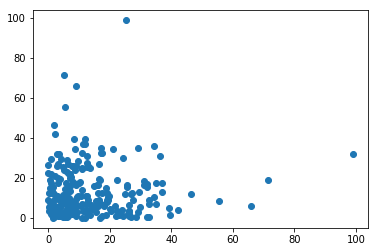

In [31]:
p = plt.scatter(과거의코스변화, 다음날코스변화)

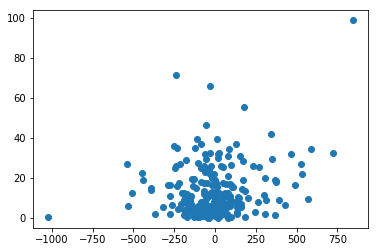

In [32]:
p = plt.scatter(과거의다우변화, 다음날코스변화)

In [33]:
np.corrcoef(과거의코스변화, 다음날코스변화)

array([[1.        , 0.01574767],
       [0.01574767, 1.        ]])

In [34]:
np.corrcoef(과거의다우변화, 다음날코스변화)

array([[1.        , 0.21239088],
       [0.21239088, 1.        ]])

In [35]:
input_seq = 60 #window
output_seq = 30
m = len(df) - (input_seq + output_seq) + 1
len(df), m

(237, 148)

In [36]:
df = (df - df.min()) / (df.max() - df.min()) #min_max정규화
x_list = []
y_list = []

In [37]:
for i in range(m):
    x = df.iloc[i:i+input_seq]
    y = df.iloc[i+input_seq:i+input_seq+output_seq][['체결가','Close']] # 여러개를 꺼내고 싶으면 대괄호로 묶으면 된다.
    # print(x.shape, y.shape)
    x_list.append(x)
    y_list.append(y)

In [38]:
len(x_list), type(x_list)

(148, list)

In [39]:
np.stack(x_list, axis=0).shape

(148, 60, 11)

In [40]:
x_3d=np.stack(x_list, axis=0)
y_3d=np.stack(y_list, axis=0)

In [41]:
x_3d.shape, y_3d.shape

((148, 60, 11), (148, 30, 2))

In [42]:
test_ratio=0.1
test_m = int(len(x_3d)*test_ratio)
test_m

14

In [43]:
m = len(x_3d)
x_2d = np.reshape(x_3d, [m,-1])
y_2d = np.reshape(y_3d, [m,-1])
x_test = x_2d[:test_m]
x_train = x_2d[test_m:]
y_test = y_2d[:test_m]
y_train = y_2d[test_m:]

In [44]:
model = Ridge(normalize=True, solver='lsqr').fit(x_train, y_train) # 2차원 이하만 가능

In [45]:
model.score(x_train, y_train), model.score(x_test, y_test)

(0.9863776513097169, -1.3382740062215221)

In [46]:
recent = df.iloc[-input_seq:]
recent.shape

(60, 11)

In [47]:
recent = np.reshape(np.array(recent), [1,-1])
recent.shape

(1, 660)

In [48]:
recent[:,:5]

array([[0.70475216, 0.05811603, 0.58971142, 0.45204413, 0.71322311]])

In [49]:
p = model.predict(recent)#미래 예측
p = np.reshape(p, [output_seq, -1])
p.shape

(30, 2)

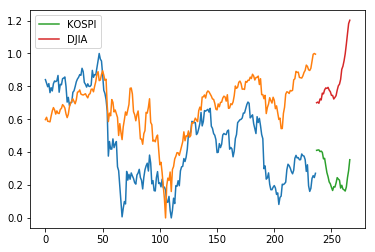

In [50]:
xm = len(df)
plt.plot(np.arange(xm), df['체결가'].values)
plt.plot(np.arange(xm), df['Close'].values)
plt.plot(np.arange(xm,xm+output_seq), p[:,0], label='KOSPI')
plt.plot(np.arange(xm,xm+output_seq), p[:,1], label='DJIA')
plt.legend()

In [96]:
p

array([[0.41095064, 0.70057866],
       [0.41280455, 0.70445665],
       [0.41354179, 0.69711017],
       [0.40314939, 0.72346772],
       [0.40622195, 0.71721421],
       [0.39888283, 0.75887239],
       [0.35916026, 0.75447382],
       [0.36257151, 0.779054  ],
       [0.3183537 , 0.79049738],
       [0.27563229, 0.78743867],
       [0.25080323, 0.79399128],
       [0.21879579, 0.77743875],
       [0.20726628, 0.76772015],
       [0.18563152, 0.74523363],
       [0.16672882, 0.74518893],
       [0.19000099, 0.72327639],
       [0.18738905, 0.73258704],
       [0.21211984, 0.74344849],
       [0.24487268, 0.77654865],
       [0.23601322, 0.80332667],
       [0.22949581, 0.81344432],
       [0.1815556 , 0.84252413],
       [0.1986439 , 0.90367572],
       [0.17556061, 0.92242985],
       [0.17074646, 0.95543117],
       [0.16333438, 0.99809683],
       [0.18832165, 1.05670003],
       [0.24550404, 1.12052531],
       [0.2882066 , 1.18197972],
       [0.35405585, 1.20217159]])

2. loan default prediction > classfication
   input : 검색
   - bank 예제 사용

In [51]:
df = pd.read_csv('bank/bank.csv',sep=';')

In [52]:
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.5+ KB


(   age          job  marital  education default  balance housing loan  \
 0   30   unemployed  married    primary      no     1787      no   no   
 1   33     services  married  secondary      no     4789     yes  yes   
 2   35   management   single   tertiary      no     1350     yes   no   
 3   30   management  married   tertiary      no     1476     yes  yes   
 4   59  blue-collar  married  secondary      no        0     yes   no   
 
     contact  day month  duration  campaign  pdays  previous poutcome   y  
 0  cellular   19   oct        79         1     -1         0  unknown  no  
 1  cellular   11   may       220         1    339         4  failure  no  
 2  cellular   16   apr       185         1    330         1  failure  no  
 3   unknown    3   jun       199         4     -1         0  unknown  no  
 4   unknown    5   may       226         1     -1         0  unknown  no  ,
 None)

In [53]:
df.isna().sum().sum()

0

In [54]:
# EDM
j= df['job']
j.value_counts()

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

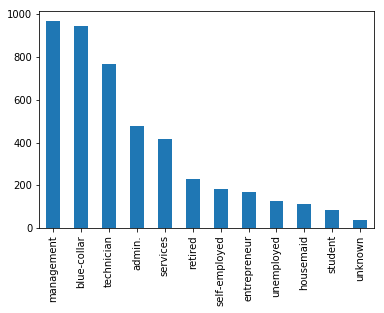

In [55]:
j.value_counts().plot.bar()

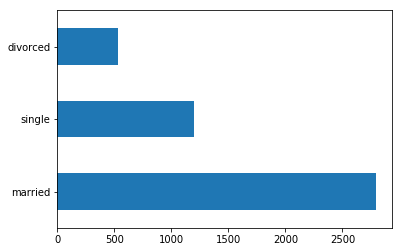

In [56]:
df.marital.value_counts().plot.barh()

In [57]:
(df['y']=='yes').mean()

0.11523999115239991

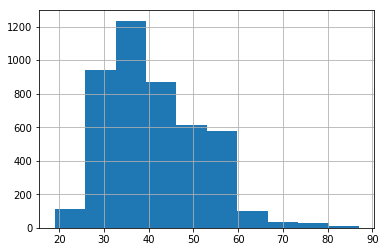

In [58]:
df['age'].hist()

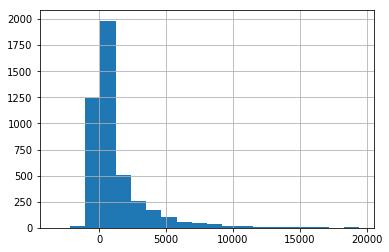

In [59]:
df[df.balance <20000].balance.hist(bins=20)

In [60]:
df2 = df.iloc[:,:-1]

In [61]:
# 원핫 인코딩 준비
# day는 int가 아닌 object여야 한다.
df2['day'] = df2['day'].astype('object')
df2.head(), df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null object
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
dtypes: int64(6), object(10)
memory usage: 565.2+ KB


(   age          job  marital  education default  balance housing loan  \
 0   30   unemployed  married    primary      no     1787      no   no   
 1   33     services  married  secondary      no     4789     yes  yes   
 2   35   management   single   tertiary      no     1350     yes   no   
 3   30   management  married   tertiary      no     1476     yes  yes   
 4   59  blue-collar  married  secondary      no        0     yes   no   
 
     contact day month  duration  campaign  pdays  previous poutcome  
 0  cellular  19   oct        79         1     -1         0  unknown  
 1  cellular  11   may       220         1    339         4  failure  
 2  cellular  16   apr       185         1    330         1  failure  
 3   unknown   3   jun       199         4     -1         0  unknown  
 4   unknown   5   may       226         1     -1         0  unknown  , None)

In [62]:
df_hot = pd.get_dummies(df2)

In [63]:
#원 핫 인코딩
df_hot = pd.get_dummies(df2)

In [64]:
df_hot.columns

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'month_apr', 'month_aug', 'month_dec', 'month_f

In [65]:
X = df_hot
y = df.iloc[:,-1]
X.head(), y.head()

(   age  balance  duration  campaign  pdays  previous  job_admin.  \
 0   30     1787        79         1     -1         0           0   
 1   33     4789       220         1    339         4           0   
 2   35     1350       185         1    330         1           0   
 3   30     1476       199         4     -1         0           0   
 4   59        0       226         1     -1         0           0   
 
    job_blue-collar  job_entrepreneur  job_housemaid  ...  month_jun  \
 0                0                 0              0  ...          0   
 1                0                 0              0  ...          0   
 2                0                 0              0  ...          0   
 3                0                 0              0  ...          1   
 4                1                 0              0  ...          0   
 
    month_mar  month_may  month_nov  month_oct  month_sep  poutcome_failure  \
 0          0          0          0          1          0              

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state=42) # test_size = 0.25, random_state=42

In [67]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3390, 81), (1131, 81), (3390,), (1131,))

In [68]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.883289124668435

In [69]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr.score(X_test, y_test)

C:\Users\wtime\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8983200707338639

In [70]:
model = DecisionTreeClassifier(max_depth=3).fit(X_train,y_train)
model.score(X_test, y_test)

0.8983200707338639

In [71]:
rf = RandomForestClassifier(n_estimators=100).fit(X_train,y_train)
rf.score(X_test,y_test)

0.9018567639257294

In [72]:
rf.feature_importances_, df.columns

(array([0.08229273, 0.07621958, 0.22873266, 0.03403555, 0.03632812,
        0.02322306, 0.00884848, 0.00973125, 0.00279932, 0.00472441,
        0.01077008, 0.00808761, 0.00378   , 0.00560435, 0.00429029,
        0.01135288, 0.00222003, 0.00218032, 0.00855309, 0.01238242,
        0.01020902, 0.0076964 , 0.0127817 , 0.01199516, 0.00565178,
        0.00204303, 0.00246779, 0.01255823, 0.01075441, 0.00654592,
        0.00656714, 0.00923235, 0.00549593, 0.00904859, 0.00450344,
        0.00480789, 0.00373652, 0.00172666, 0.00645832, 0.00476885,
        0.00401267, 0.00365928, 0.00467844, 0.00403041, 0.00393622,
        0.00713267, 0.00528487, 0.00564174, 0.00486771, 0.00659839,
        0.00383238, 0.00809133, 0.00281416, 0.00471301, 0.00618307,
        0.00390817, 0.00325164, 0.00312342, 0.00247658, 0.00397633,
        0.00468559, 0.0039253 , 0.00282263, 0.00795129, 0.00082261,
        0.01307114, 0.00933592, 0.00319725, 0.0065301 , 0.00295806,
        0.0083947 , 0.01127654, 0.01247767, 0.01

<BarContainer object of 81 artists>

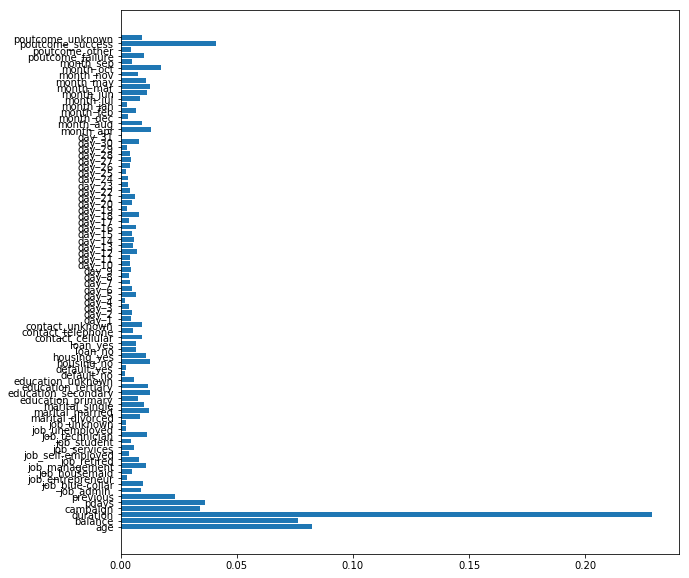

In [73]:
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, rf.feature_importances_)

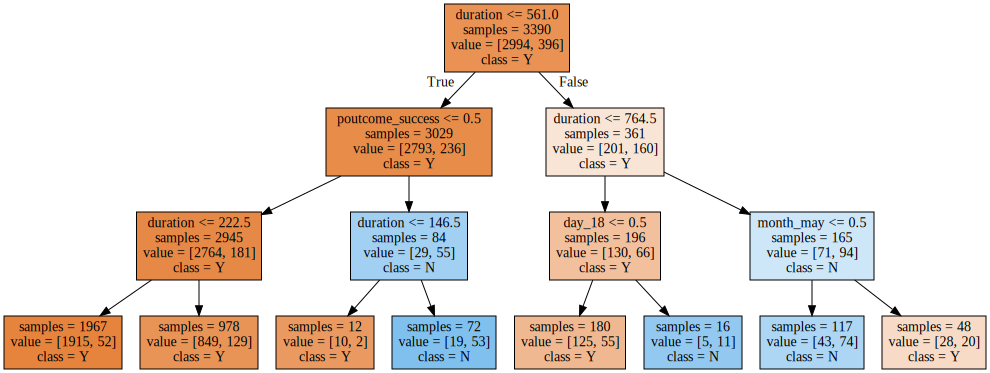

In [74]:
export_graphviz(model, out_file='loan.dot', class_names=['Y','N'], feature_names=X.columns, impurity=False, filled=True)
with open('loan.dot') as f:
    dot_graph = f.read()
g = graphviz.Source(dot_graph)
display(g)

3. credit card froud detection > clustering
   input : 검색
   - https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3
   - v1 ~ v28은 민감정보로 보여짐..
   - may be result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)

In [75]:
folder = 'creditcardfraud/'
file = 'creditcard.csv'

In [76]:
fraud = pd.read_csv(folder + file)

In [77]:
fraud.head(), fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
 3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
 4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
 
         V26      

In [78]:
# 데이터가 많아 일단 10000개로만 TEST
# 전체 데이터로 테스트 하려고 하였으나, memory error로 다시 축소하여 진행 > MemoryError:
fraud = fraud.iloc[:10000]
#fraud = fraud.iloc[:30000]

In [79]:
fraud.info(), fraud.tail(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
Time      10000 non-null float64
V1        10000 non-null float64
V2        10000 non-null float64
V3        10000 non-null float64
V4        10000 non-null float64
V5        10000 non-null float64
V6        10000 non-null float64
V7        10000 non-null float64
V8        10000 non-null float64
V9        10000 non-null float64
V10       10000 non-null float64
V11       10000 non-null float64
V12       10000 non-null float64
V13       10000 non-null float64
V14       10000 non-null float64
V15       10000 non-null float64
V16       10000 non-null float64
V17       10000 non-null float64
V18       10000 non-null float64
V19       10000 non-null float64
V20       10000 non-null float64
V21       10000 non-null float64
V22       10000 non-null float64
V23       10000 non-null float64
V24       10000 non-null float64
V25       10000 non-null float64
V26       10000 non-null float64
V

(None,
          Time        V1        V2        V3        V4        V5        V6  \
 9980  14940.0  0.509465  1.906159 -2.579983  1.502234  1.395695 -0.798737   
 9981  14941.0 -0.619870  1.077871  1.721085 -0.386582  0.148880 -0.701113   
 9982  14951.0  1.113690  0.761906  1.071124  2.757166 -0.101429 -0.306094   
 9983  14964.0  0.989131 -0.413148  1.213739  0.746907 -0.739761  0.880300   
 9984  14973.0 -1.468494 -0.386998  2.532221  1.455805 -0.779682  0.223008   
 9985  14981.0 -1.372980  1.779108  0.994216  0.290827 -0.849137 -1.171900   
 9986  14988.0 -1.010979  0.956151  2.080257  0.287531 -0.531395  0.303162   
 9987  14989.0 -1.978648  1.866610  0.288459 -0.078206 -0.031190  0.004884   
 9988  14989.0  1.214663  0.637900  0.156007  1.329216  0.216616 -0.842642   
 9989  14989.0  0.973806  0.711426  1.328342  3.790438  0.011453  0.634382   
 9990  14993.0 -0.379366  1.168437 -0.702738  0.566445  1.952919  4.638911   
 9991  14993.0  1.040248  0.288967  1.637475  2.943149 -0

In [80]:
fraud.isna().sum().sum()

0

In [81]:
fraud.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [82]:
fraud2 = fraud.set_index('Time')

In [83]:
fraud2 = fraud2.drop(columns='Class')

In [84]:
fraud2.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [85]:
pca = PCA(n_components=2).fit(fraud2)

In [86]:
x_pca = pca.transform(fraud2)

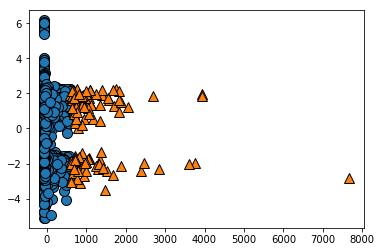

In [87]:
# 1. means
km = KMeans(n_clusters=2).fit(x_pca) # 2개로 그룹화
p1 = km.predict(x_pca)
l = mglearn.discrete_scatter(x_pca[:,0],x_pca[:,1], p1)

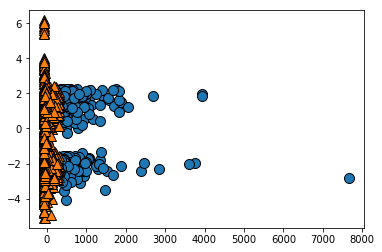

In [88]:
# 2. 병합군집
model1 = AgglomerativeClustering(n_clusters=2)
p2 = model1.fit_predict(x_pca)
l = mglearn.discrete_scatter(x_pca[:,0],x_pca[:,1], p2)

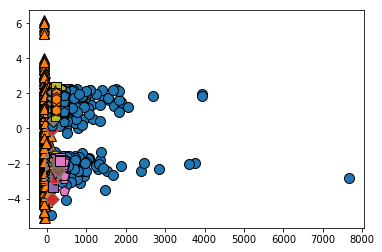

In [89]:
#3. DBSCAN
p3 = DBSCAN(eps=2, min_samples=5).fit_predict(x_pca)
l = mglearn.discrete_scatter(x_pca[:,0],x_pca[:,1], p3)

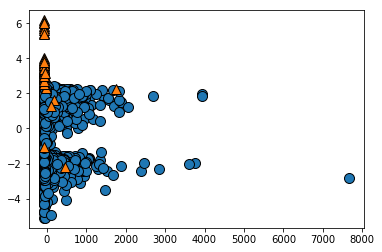

In [90]:
# 정답
l = mglearn.discrete_scatter(x_pca[:,0],x_pca[:,1], fraud.iloc[:,-1])

In [91]:
X = fraud2
y = fraud.iloc[:,-1]
X.head(), y.head()

(            V1        V2        V3        V4        V5        V6        V7  \
 Time                                                                         
 0.0  -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 0.0   1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 1.0  -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 1.0  -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 2.0  -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
             V8        V9       V10  ...       V20       V21       V22  \
 Time                                ...                                 
 0.0   0.098698  0.363787  0.090794  ...  0.251412 -0.018307  0.277838   
 0.0   0.085102 -0.255425 -0.166974  ... -0.069083 -0.225775 -0.638672   
 1.0   0.247676 -1.514654  0.207643  ...  0.524980  0.247998  0.771679   
 1.0   0.377436 -1.387024 -0.054952  ... -0.208038 -0.108300  0.005274   
 

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 29), (2500, 29), (7500,), (2500,))

In [93]:
model = DecisionTreeClassifier(max_depth=5).fit(X_train,y_train)

In [94]:
model.score(X_train, y_train), model.score(X_test, y_test)

(1.0, 0.9984)

<BarContainer object of 29 artists>

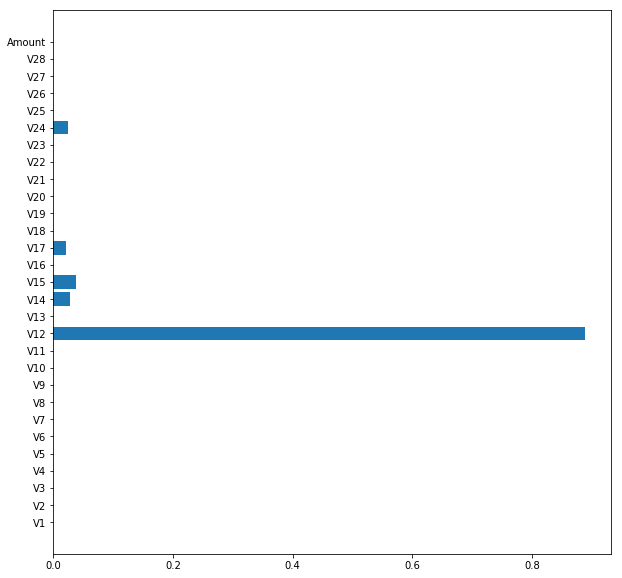

In [95]:
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, model.feature_importances_)